In [1]:
%load_ext Cython

In [2]:
%%cython
cimport numpy as np
import numpy as np
import warnings
from numpy cimport ndarray, int64_t, float64_t, intp_t

ctypedef fused ordered:
    np.intp_t
    np.int32_t
    np.int64_t
    np.float32_t
    np.float64_t
    np.ndarray

from scipy.stats import multiscale_graphcorr


def classes(y):
    return(np.unique(y)).astype('int64')

def concatenate_x_y(matrices):
    return(np.concatenate(matrices).astype('float64'))

def to_int_64(y):
    return (y.astype('int64'))

def mgc_stat(X,y):
    mgc = multiscale_graphcorr(X,y,reps = 0)
    return np.float64(mgc.stat)

def one_hot_y(unique_arr, matrices):
    encode_view = []
    class_number = len(unique_arr)
    vs = []
    for k in range(class_number):
        n = matrices[k].shape[0]
        encode_view = np.zeros(shape=(n, class_number), dtype = np.float64)
        encode_view[:, k] = np.ones(shape=n, dtype = np.float64)
        vs.append(encode_view)
    return vs

cpdef list k_matrices(float64_t [:, :] X_view, int64_t [:] y_int_view, int64_t [:] unique_view, intp_t shape):
    cdef list indices_view  = []
    cdef intp_t j 
    cdef intp_t i
    cdef list matrices = []
    cdef float64_t [:,:] xi_view
    for j in range(len(unique_view)):
        indices_view = []        
        for i in range(len(y_int_view)):
            if y_int_view[i] == unique_view[j]:
                indices_view.append(i)
        if shape == 1:
            xi_view = X_view.base[indices_view]
        else:
            xi_view = X_view.base[indices_view,:]
        matrices.append(xi_view)
    return matrices
    
    

cpdef np.float64_t k_sample_test(float64_t [:, :] X_view , float64_t [:] y_view, str score_func = 'mgc'):
    """Nonparametric `K`-Sample Testing test statistic.
     
    A k-sample test tests equality in distribution among groups. Groups
    can be of different sizes, but must have the same dimensionality.
    This implementation reduces the k-sample testing to an 
    independence testing problem, and leverages notable and powerful
    multivariate independence tests.
    
    Read more in the :ref:`User Guide <multivariate_feature_selection>`.
    
    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Sample vectors.
    y : ndarray of shape (n_samples,)
        The target vector.
    score_func : string that refers to a multivariate independence test from scipy
        The default and only existing test is multiscale graph correlation.
    
    Returns
    -------
    stat : float that refers to the computed k-sample test statistic
    
    Notes
    -----
    1. The k-sample testing problem can be thought of as a generalization of
    the two sample testing problem. 
    
    2. By manipulating the inputs of the k-sample test, we create
    concatenated versions of the inputs and a label matrix which are
    paired. Then, any multivariate nonparametric test can be performed on
    this data.
    
    3. Multivariate feature selection uses k-sample test score function to
    calculate a test statistic for each feature not already selected as a 
    best feature. For each feature in that sub-section, inputted is a data matrix 
    with best features selected and that additional feature.
    
    References
    ----------
    .. [1] Sambit Panda, Cencheng Shen, Ronan Perry, Jelle Zorn, Antoine Lutz, 
           Carey E. Priebe, and Joshua T. Vogelstein. Nonpar MANOVA via 
           Independence Testing. arXiv:1910.08883 [cs, stat], April 2021. 

    """
    # extract data matrix of shape (_samples,_features) for each group

     # unsure if needs to be rewritten in cython
    cdef intp_t shape = len(X_view.shape)
    cdef int64_t [:] unique_view = classes(np.asarray(y_view))
    cdef int64_t [:] y_int_view = to_int_64(np.asarray(y_view))
    cdef list matrices = k_matrices(X_view,y_int_view,unique_view,shape)
    X_view = concatenate_x_y(matrices)
    # one hot encode y for multivariate independence test
    cdef float64_t [:,:] y_final_view  = concatenate_x_y(one_hot_y(np.asarray(unique_view),matrices))
    cdef float64_t stat
    # default, which is mgc case
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        stat = mgc_stat(np.asarray(X_view),np.asarray(y_final_view))#unsure of cythonizing
    return stat




In [5]:
from sklearn.base import BaseEstimator
from sklearn.feature_selection import SelectorMixin
import numpy as np
from scipy.stats import multiscale_graphcorr
from scipy.sparse import isspmatrix
import warnings
from sklearn.utils.validation import check_is_fitted
from joblib import Parallel, delayed

class MultivariateFeatureSelector(SelectorMixin, BaseEstimator):
    """ Transformer that performs forward selection.
    
    This feature selector adds features (forward selection) to
    form a feature subset. At each iteration, a parallel 
    operation occurs in which a multivariate independence test 
    is performed for each data matrix with the selected best 
    features and an additional feature not yet selected. The 
    additional feature associated with the highest multivariate
    independence test statistic is then chosen as the next best 
    feature. 
    
    Read more in the :ref:`User Guide <multivariate_feature_selection>`.
    
    Parameters
    ----------
    k: int, default=10
        amount of features to select. 
        
    Attributes
    ----------
    features_ : array, shape (n_features,)
        indices of all features in X
    
    best_features_ : array, shape (k,)
         indices of selected k best features of features_
         
    Examples
    --------
    >>> from sklearn.datasets import load_digits
    >>> from sklearn.feature_selection import MultivariateFeatureSelector
    >>> X, y = load_digits(return_X_y=True)
    >>> X.shape
    (1797, 64)
    >>> X_new = MultivariateFeatureSelector(k = 7).fit_transform(X, y)
    >>> X_new.shape
    (1797, 7)
    """
    
    def __init__(self, k=10):
        self.k = k
        
    def _test_stat(self, X_new, y, best_features, index):
        # helper function for calculating, in parallel, 
        # test statistic associated with
        # selected best features and an additional feature 
        if np.var(X_new[:,index]) == 0:
            stat = -1.0
        else:   
            columns = best_features.copy() 
            columns.append(index)
            X_j = X_new[:,columns]
            stat = k_sample_test(X_j.astype('float64'),y.astype('float64'))
        return stat
        
        
    def fit(self, X, y,workers = -1):
        """Learn the features to select from X.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training vectors, where `n_samples` is the number of samples and
            `n_features` is the number of predictors.
        y : array-like of shape (n_samples,), default=None
            Target values. 
        
        Returns
        -------
        self : object
            Returns the instance itself.
        """
        if isspmatrix(X) == True:
            X = X.toarray()
        
        # array of indices that correspond to features,
        # at each iteration, the selected best feature
        # is removed from this array
        features = np.arange(X.shape[1])
        
        if np.isnan(X).any() == True:
            raise ValueError("existing multivariate independence tests in scipy do not allow nan")
        if type(self.k) is not int:
            raise TypeError("k is type {}, must be int".format(type(self.k)))
        if not 0 < self.k and self.k <= X.shape[1]:
                raise ValueError("k is {}, must be nonnegative <= number of features of X".format(self.k))
        if not X.shape[0] >= 5:
                raise ValueError("number of samples is {}, must be >= 5".format(X.shape[0]))
        
        # loop to select feature subset, 
        # each iteration adds next best feature as 
        # determined by the mulitivariate independence test
        # as we rank each additional feature by statistic
        best_features = []
        while len(best_features) < self.k: 
            X_new = np.array(X)
            
            # Parallel process for test statistic calculations 
            # of selected best features and each additional feature.
            # size of operations in parallel per loop iteration is 
            # n_features - len(best_features)
            scores = list(
                Parallel(n_jobs=workers)(
                    [
                        delayed(self._test_stat)(X_new,y,best_features,index)
                        for index in features
                    ]
                )
            )

            scores_index = np.column_stack((features,np.array(scores)))
            sorted_index = scores_index[scores_index[:,1].argsort()] 
            best = int(sorted_index[len(scores)-1,0])
            best_features.append(best) 
            features = np.delete(features,np.where(features == best)) 
        self.best_features_ = best_features
        self.features_ = np.arange(X.shape[1])
        return self
    
    def _get_support_mask(self):
        check_is_fitted(self)
        return  np.array([x in self.best_features_ for x in self.features_])
    
    def _more_tags(self):
        return {"allow_nan": False,"requires_y": True}




In [3]:

from sklearn.datasets import make_classification

func1_time = []
for j in[100,200,500,1000]:
    for i in [100,200,500,1000]:
        X, y = make_classification(
            n_samples=j,
            n_features=i,
            n_informative=10,
            n_redundant=5,
            n_repeated=0,
            n_classes=4,
            n_clusters_per_class=3,
            flip_y=0.0,
            class_sep=4,
            shuffle=False,
            random_state=0,
        )
        foo =  %timeit -o k_sample_test(X.astype('float64'),y.astype('float64'))
        func1_time.append(foo)
print(func1_time)

6.41 ms ± 374 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.51 ms ± 242 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.2 ms ± 361 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
17.2 ms ± 141 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
15.9 ms ± 112 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
20.4 ms ± 118 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
35.3 ms ± 391 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
58.8 ms ± 112 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
79.3 ms ± 369 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
107 ms ± 979 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
193 ms ± 1.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
367 ms ± 12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
427 ms ± 5.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
566 ms ± 48.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
914 ms ± 17 ms per loop 

In [6]:
%%timeit
from sklearn.datasets import load_digits

X, y = load_digits(return_X_y=True)
MultivariateFeatureSelector(k = 7).fit_transform(X,y)

exception calling callback for <Future at 0x12e052358 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py", line 404, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
ModuleNotFoundError: No module named '_cython_magic_f390194c8841820cfe4707fa3bdd86be'
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 359, in __call__
    self.parallel.dispatch_next()
  File "/anaconda3/lib/python3.7/site-packages/joblib/parallel

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [5]:
from sklearn.base import BaseEstimator
from sklearn.feature_selection import SelectorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
import numpy as np
from scipy.stats import multiscale_graphcorr
from scipy._lib._util import MapWrapper
import warnings

def k_sample_test_2(X, y,score_func="mgc"):
    """Compute the multivariate independence test statisitic for the provided sample.
    Read more in the :ref:`User Guide <multivariate_feature_selection>`.
    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        The set of regressors that will be tested sequentially.
    y : ndarray of shape (n_samples,)
        The target vector.
    score_func : string that refers to a k_sample multivariate independence test from scipy
                The default and only existing test is multiscale graph correlation.
    Returns
    -------
    stat : float that refers to the computed k_sample test statistic
    """
    k_array = np.unique(y)
    matrices = []
    for i in k_array:
        indices = np.where(y == i)[0] 
        if len(X.shape) == 1:
            xi = X[indices]
        else:
            xi = X[indices,:]
        matrices.append(xi)
    X = np.concatenate(matrices)
    vs = []
    for i in range(len(np.unique(y))):
        n = matrices[i].shape[0]
        encode = np.zeros(shape=(n, len(matrices)))
        encode[:, i] = np.ones(shape=n)
        vs.append(encode)
    y = np.concatenate(vs)
    warnings.filterwarnings("ignore")
    mgc = multiscale_graphcorr(X,y,reps = 0)
    stat = mgc.stat #mgc case
    return(stat)



In [6]:
for j in[100,200,500,1000]:
    for i in [100,200,500,1000]:
        X, y = make_classification(
            n_samples=j,
            n_features=i,
            n_informative=10,
            n_redundant=5,
            n_repeated=0,
            n_classes=4,
            n_clusters_per_class=3,
            flip_y=0.0,
            class_sep=4,
            shuffle=False,
            random_state=0,
        )
        foo =  %timeit -o k_sample_test_2(X.astype('float64'),y.astype('float64'))
        func1_time.append(foo)

6.18 ms ± 17.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.79 ms ± 404 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.6 ms ± 394 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
18 ms ± 800 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
17.1 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
20.7 ms ± 103 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
38.7 ms ± 4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
62.7 ms ± 3.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
81.8 ms ± 7.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
108 ms ± 773 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
192 ms ± 1.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
353 ms ± 1.97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
433 ms ± 36.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
549 ms ± 21.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
930 ms ± 25 ms per loo

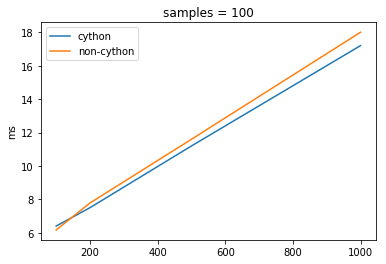

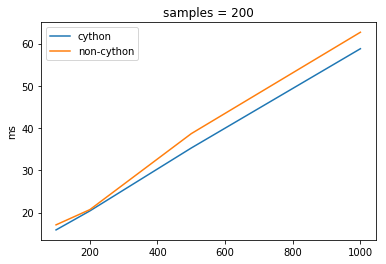

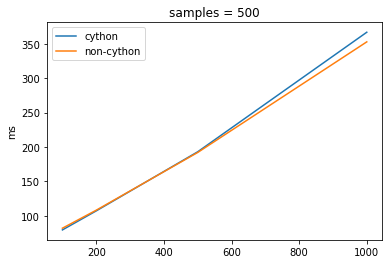

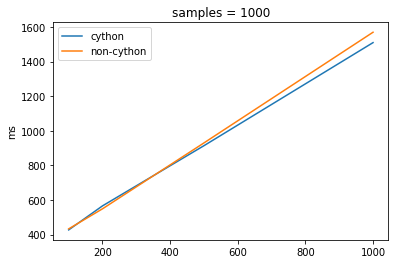

In [20]:
import matplotlib.pyplot as plt
plt.plot([100,200,500,1000],[6.41,7.51,11.2,17.2], label = 'cython')
plt.plot([100,200,500,1000],[6.18,7.79,11.6,18], label = 'non-cython')
plt.title('samples = 100')
plt.ylabel('ms')
plt.legend()
plt.show()
plt.plot([100,200,500,1000],[15.9,20.4,35.3,58.8], label = 'cython')
plt.plot([100,200,500,1000],[17.1,20.7,38.7,62.7], label = 'non-cython')
plt.title('samples = 200')
plt.ylabel('ms')
plt.legend()
plt.show()
plt.plot([100,200,500,1000],[79.3,107,193,367], label = 'cython')
plt.plot([100,200,500,1000],[81.8,108,192,353], label = 'non-cython')
plt.title('samples = 500')
plt.ylabel('ms')
plt.legend()
plt.show()
plt.plot([100,200,500,1000],[427,566,914,1510], label = 'cython')
plt.plot([100,200,500,1000],[433,549,930,1570], label = 'non-cython')
plt.title('samples = 1000')
plt.ylabel('ms')
plt.legend()
plt.show()